# Heart Gesture Recognition
This jupyter notebook has been used to generate and train the heart gesture recognition neural network.

In [4]:
#installation of libraries and packages if needed
%pip install imageio
%pip install scikit-image
%pip install matplotlib
%pip install tensorflow
%pip install keras #high level API for tensorflow
%pip install pandas
%pip install opencv-python

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
#Importing libraries

import numpy as np
import os

import random as rn
import warnings
from pathlib import Path
import imageio
from imageio.v2 import imread
from skimage.transform import resize
import datetime
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import backend as K

import cv2
import pandas as pd
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation, Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers


## Settings

In [ ]:
warnings.filterwarnings("ignore")

We set the random seed so that the results don't vary drastically.

In [7]:
print(tf.__version__)
print(keras.__version__)

2.19.0
3.9.2


In [8]:
np.random.seed(30)
rn.seed(30)
seed = tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity.

In [ ]:
#Filippo's path
model = Path('/Users/filippo/Library/CloudStorage/OneDrive-PolitecnicodiMilano/Corsi/Creative Programming and Computing ⌨️/HACKATON/Codici interessanti/DATASET/DS4_HEART')

train_doc = np.random.permutation((model / 'train/labelled_train.csv').read_text().splitlines())
val_doc = np.random.permutation((model / 'valid/labelled_val.csv').read_text().splitlines())

batch_size = 32 #experiment with the batch size. Volendo si può alzare o abbassare
num_classes = 2 # Number of classes (0 and 1 for binary classification)


print(f'Train length: {len(train_doc)-1}')  # -1 because the first line is the header
print(f'Validation length: {len(val_doc)-1}')  # -1 because the first line is the header


Train length: 1159
Validation length: 306


## Generator
In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch.

In [10]:
def preprocess_image(image, channel, height, width):
    image = resize_image(image, height, width)
    return normalise_image(image, channel)

In [11]:
def normalise_image(image, channel):
    return (image[...,channel])/255

In [12]:
def resize_image(image, height, width):
    h, w, c = image.shape
    return resize(image, (height, width), anti_aliasing=True)

In [13]:
def getImgTensor(n_frames):
    img_idx = np.round(np.linspace(0, 29, n_frames)).astype(int)
    return [img_idx, 120, 120, 3]

In [14]:
def generate_common(t, source_path, batch_size, img_idx, batch, batch_data, batch_labels, height=120, width=120, augment=False):
    ''' 
    parameters:
        t: train_doc or val_doc (type of data)
        source_path: path of the images
        batch_size: batch size
        img_idx: list of frames to be considered
        batch: batch number
        batch_data: numpy array to store the data (output)
        batch_labels: numpy array to store the labels (output)
        height: height of the image
        width: width of the image
        augment: boolean to augment the images
    '''

    for folder in range(batch_size): # iterate over the batch_size
        imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
        for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
            image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
            

            # Randomly transform few images of few folders; note that folders are randomly shuffled in each epoch too
            if augment:
                image = resize_image(image, height, width)
                if np.random.randn() > 0:
                    image = datagen.random_transform(image) #random transformation of the image to augment the dataset dimension                   

            #crop the images and resize them. Note that the images are of 2 different shape 
            #and the conv3D will throw error if the inputs in a batch have different shapes
            
            batch_data[folder,idx,:,:,0] = preprocess_image(image, 0, height, width) #normalise and feed in the image
            batch_data[folder,idx,:,:,1] = preprocess_image(image, 1, height, width) #normalise and feed in the image
            batch_data[folder,idx,:,:,2] = preprocess_image(image, 2, height, width) #normalise and feed in the image                  
            
        batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1

    return batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

In [ ]:
def extract_common_name(filename):
    """Estrae la parte del nome file che inizia da 'jpg'."""
    parts = filename.split("_jpg")  # Divide il nome sul primo '_jpg'
    if len(parts) > 1:
        return "jpg" + parts[1]  # Ricostruisce la parte comune mantenendo 'jpg'
    return filename  # In caso di errore, ritorna il nome originale


def load_labels(csv_path):
    """Carica il file CSV e crea un dizionario {parte_comune: label_index}."""
    df = pd.read_csv(csv_path, sep=";")
    label_map = {"hand": 0, "heart": 1}  # Mappatura delle classi
    
    labels_dict = {}
    for _, row in df.iterrows():
        common_name = extract_common_name(row["filename"])  # Normalizza il nome
        labels_dict[common_name] = label_map[row["label"]]  # Assegna la classe
    
    return labels_dict


def generate(source_path, csv_path, batch_size, height=120, width=120, augment=False):
    labels_dict = load_labels(csv_path)
    image_list = os.listdir(source_path)
    valid_images = [img for img in image_list if extract_common_name(img) in labels_dict]

    while True:
        np.random.shuffle(valid_images)
        num_batches = len(valid_images) // batch_size

        for batch in range(num_batches + 1):
            start = batch * batch_size
            end = min((batch + 1) * batch_size, len(valid_images))
            batch_files = valid_images[start:end]

            batch_data = np.zeros((len(batch_files), height, width, 3))  # 3 canali per RGB
            batch_labels = np.zeros((len(batch_files), 2))  # 2 classi

            for i, file in enumerate(batch_files):
                img = cv2.imread(os.path.join(source_path, file))
                img = cv2.resize(img, (width, height))
                batch_data[i] = img / 255.0  # Normalizza i pixel

                common_name = extract_common_name(file)
                label = labels_dict[common_name]
                batch_labels[i] = to_categorical(label, num_classes=2)

            yield batch_data, batch_labels

In [16]:
curr_dt_time = datetime.datetime.now()
train_path = str(model / "train")
val_path = str(model/ "valid")

train_doc = str(model / "train" / "labelled_train.csv")
val_doc = str(model / "valid" / "labelled_val.csv")

batch_size = 32

train_gen = generate(train_path, train_doc, batch_size)
val_gen = generate(val_path, val_doc, batch_size)

num_train_sequences = len(train_doc)

print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 40 #choose the number of epochs, the order of the sum
print ('# epochs =', num_epochs)

# training sequences = 180
# validation sequences = 178
# epochs = 40


#### Validating the Generator

In [17]:
# check complete batch shape
sample_generator = generate(train_path, train_doc, batch_size)
sample_batch_data, sample_batch_labels = next(sample_generator)
if sample_batch_data.shape[0] < batch_size:
	print(f"Warning: Only {sample_batch_data.shape[0]} samples in this batch (expected {batch_size}).")
print(f"Shape of the batch data (sample): {sample_batch_data.shape}")

# Check for batch size before accessing indices
if sample_batch_data.shape[0] > 1:
	print("Accessing sample_batch_data[1] is safe.")
else:
	print("Batch too small to access index 1 in sample_batch_data.")

# validation batch sample
sample_val_generator = generate(val_path, val_doc, batch_size)
sample_val_batch_data, sample_val_batch_labels = next(sample_val_generator)
if sample_val_batch_data.shape[0] < batch_size:
	print(f"Warning: Only {sample_val_batch_data.shape[0]} samples in this validation batch (expected {batch_size}).")
print(f"Shape of the batch data (sample_val): {sample_val_batch_data.shape}")

if sample_val_batch_data.shape[0] > 1:
	print("Accessing sample_val_batch_data[1] is safe.")
else:
	print("Validation batch too small to access index 1 in sample_val_batch_data.")



Shape of the batch data (sample): (32, 120, 120, 3)
Accessing sample_batch_data[1] is safe.
Shape of the batch data (sample_val): (32, 120, 120, 3)
Accessing sample_val_batch_data[1] is safe.


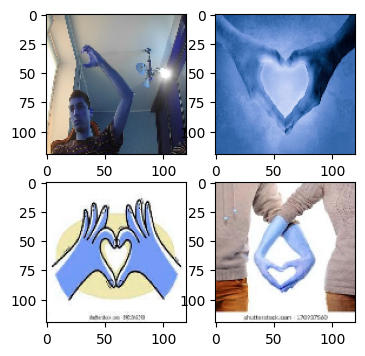

In [18]:
fig, ax = plt.subplots(2, 2, figsize=(4, 4))

ax[0,0].imshow(sample_batch_data[17])  # Seleziona immagine 16
ax[0,1].imshow(sample_batch_data[22])  # Seleziona immagine 25

ax[1,0].imshow(sample_val_batch_data[11])  # Seleziona immagine 16 dal validation set
ax[1,1].imshow(sample_val_batch_data[21])  # Seleziona immagine 25 dal validation set

plt.show()


## Model
Here you make the model using different functionalities that Keras provides. 

Model callback utility

In [20]:
def plot_loss_accuracy(history):
    print("Chiavi disponibili in history:", history.history.keys())  # DEBUG

    # Controllo se usare accuracy o categorical_accuracy
    accuracy_key = 'accuracy' if 'accuracy' in history.history else 'categorical_accuracy'
    val_accuracy_key = 'val_' + accuracy_key

    # Plot accuracy
    plt.plot(history.history[accuracy_key])
    plt.plot(history.history[val_accuracy_key])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()


In [21]:
def model_callbacks(folder_name):
    model_name = str(folder_name) + '_' + datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S") + '/'
   
    if not os.path.exists(model_name):
        os.mkdir(model_name)

    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{accuracy:.5f}-{val_loss:.5f}-{val_accuracy:.5f}.h5'

    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto')

    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.0001, cooldown=1, verbose=1) 

    return [checkpoint, LR]


In [22]:
def calculate_steps(num_train_sequences, num_val_sequences, batch_size):
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1

    return steps_per_epoch,validation_steps

In [23]:
# Common utility to create conv 3D models
def conv3D(conv_filters=(16, 32, 64, 128), dense_nodes=(256,128), dropout=0.25, num_images=20, height=120, width=120):

    model = Sequential()

    model.add(Conv3D(conv_filters[0], (3, 3, 3), padding='same', input_shape=(num_images, height, width, 3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(conv_filters[1], (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Conv3D(conv_filters[2], (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Conv3D(conv_filters[3], (3, 3, 3), padding='same'))    
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Flatten())
    model.add(Dense(dense_nodes[0]))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(dense_nodes[1]))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    opt = tf.keras.optimizers.Adam() #write your optimizer
    model.compile(opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])    
    
    return model

#### Model 1: 
Conv 3D Model with 30 frames per video (16, 32, 64, 128 filters conv 3D layers + 256 dense layer + 128 dense layer + image size 120 by 120)

Now that you have written the model, the next step is to compile the model. When you print the summary of the model, you'll see the total number of parameters you have to train.

In [24]:
num_epochs = 40 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 60  #experiment with the batch size
print ('# batch size =', batch_size)

model = conv3D()

print (model.summary())

# epochs = 40
# batch size = 60


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 20, 120, 120,   │         1,312 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 20, 120, 120,   │             0 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 20, 120, 120,   │            64 │
│ (BatchNormalization)            │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 10, 60, 60, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 10, 60, 60, 32) │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 10, 60, 60, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 10, 60, 60, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 5, 30, 30, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 5, 30, 30, 64)  │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 5, 30, 30, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 5, 30, 30, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 2, 15, 15, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_3 (Conv3D)               │ (None, 2, 15, 15, 128) │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 2, 15, 15, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 2, 15, 15, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 1, 7, 7, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,605,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,933,378 (7.38 MB)

 Trainable params: 1,932,130 (7.37 MB)

 Non-trainable params: 1,248 (4.88 KB)

None


Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [25]:
callbacks_list = model_callbacks("model_30_conv3D_1")
steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size)
val_generator   = generate(val_path, val_doc, batch_size)

In [26]:
model = Sequential()

# Modifica da Conv3D a Conv2D
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(120, 120, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='softmax'))  # Due classi (open e fist)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [27]:
history = model.fit(train_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=num_epochs,
                    validation_data=val_generator,
                    validation_steps=validation_steps,
                    callbacks=callbacks_list)

Epoch 1/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.5759 - loss: 4.2781
Epoch 1: saving model to model_30_conv3D_1_2025-06-18_14-11-26/model-00001-7.62454-0.51111-2.38952-0.43333.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 531ms/step - accuracy: 0.5597 - loss: 5.1147 - val_accuracy: 0.4333 - val_loss: 2.3895 - learning_rate: 0.0010
Epoch 2/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.4722 - loss: 4.7692
Epoch 2: saving model to model_30_conv3D_1_2025-06-18_14-11-26/model-00002-6.00372-0.55000-4.08539-0.66129.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 279ms/step - accuracy: 0.4917 - loss: 5.0778 - val_accuracy: 0.6613 - val_loss: 4.0854 - learning_rate: 0.0010
Epoch 3/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.6870 - loss: 2.6236
Epoch 3: saving model to model_30_conv3D_1_2025-06-18_14-11-26/model-00003-2.65592-0.64444-2.94916-0.50000.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 319ms/step - accuracy: 0.6764 - loss: 2.6317 - val_accuracy: 0.5000 - val_loss: 2.9492 - learning_rate: 0.0010
Epoch 4/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.6194 - loss: 2.0197
Epoch 4: saving model to model_30_conv3D_1_2025-06-18_14-11-26/model-00004-1.65303-0.66667-1.74385-0.73333.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 309ms/step - accuracy: 0.6313 - loss: 1.9281 - val_accuracy: 0.7333 - val_loss: 1.7438 - learning_rate: 0.0010
Epoch 5/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.7093 - loss: 1.9080
Epoch 5: saving model to model_30_conv3D_1_2025-06-18_14-11-26/model-00005-1.53976-0.74444-0.62485-0.85000.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.7181 - loss: 1.8160 - val_accuracy: 0.8500 - val_loss: 0.6249 - learning_rate: 0.0010
Epoch 6/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.8537 - loss: 0.6839
Epoch 6: saving model to model_30_conv3D_1_2025-06-18_14-11-26/model-00006-0.66954-0.86111-1.25109-0.74444.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 285ms/step - accuracy: 0.8556 - loss: 0.6803 - val_accuracy: 0.7444 - val_loss: 1.2511 - learning_rate: 0.0010
Epoch 7/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.8468 - loss: 0.9880
Epoch 7: saving model to model_30_conv3D_1_2025-06-18_14-11-26/model-00007-0.84555-0.83704-0.48814-0.87222.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.8444 - loss: 0.9524 - val_accuracy: 0.8722 - val_loss: 0.4881 - learning_rate: 0.0010
Epoch 8/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.9130 - loss: 0.3172
Epoch 8: saving model to model_30_conv3D_1_2025-06-18_14-11-26/model-00008-0.33600-0.88889-0.42649-0.87222.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 242ms/step - accuracy: 0.9069 - loss: 0.3219 - val_accuracy: 0.8722 - val_loss: 0.4265 - learning_rate: 0.0010
Epoch 9/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.8843 - loss: 0.3462
Epoch 9: saving model to model_30_conv3D_1_2025-06-18_14-11-26/model-00009-0.35405-0.89444-0.29836-0.89444.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 310ms/step - accuracy: 0.8868 - loss: 0.3482 - val_accuracy: 0.8944 - val_loss: 0.2984 - learning_rate: 0.0010
Epoch 10/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.9167 - loss: 0.3136
Epoch 10: saving model to model_30_conv3D_1_2025-06-18_14-11-26/model-00010-0.31502-0.91667-0.32121-0.90556.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 385ms/step - accuracy: 0.9167 - loss: 0.3140 - val_accuracy: 0.9056 - val_loss: 0.3212 - learning_rate: 0.0010
Epoch 11/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.9389 - loss: 0.1848
Epoch 11: saving model to model_30_conv3D_1_2025-06-18_14-11-26/model-00011-0.18549-0.93333-0.27910-0.90000.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 361ms/step - accuracy: 0.9375 - loss: 0.1850 - val_accuracy: 0.9000 - val_loss: 0.2791 - learning_rate: 0.0010
Epoch 12/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.9083 - loss: 0.2104
Epoch 12: saving model to model_30_conv3D_1_2025-06-18_14-11-26/model-00012-0.23897-0.91667-0.28449-0.91111.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 349ms/step - accuracy: 0.9104 - loss: 0.2175 - val_accuracy: 0.9111 - val_loss: 0.2845 - learning_rate: 0.0010
Epoch 13/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.9398 - loss: 0.1399
Epoch 13: saving model to model_30_conv3D_1_2025-06-18_14-11-26/model-00013-0.15887-0.92778-0.22667-0.91111.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 355ms/step - accuracy: 0.9368 - loss: 0.1446 - val_accuracy: 0.9111 - val_loss: 0.2267 - learning_rate: 0.0010
Epoch 14/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9580 - loss: 0.1203
Epoch 14: saving model to model_30_conv3D_1_2025-06-18_14-11-26/model-00014-0.16706-0.94074-0.27054-0.90556.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 247ms/step - accuracy: 0.9537 - loss: 0.1320 - val_accuracy: 0.9056 - val_loss: 0.2705 - learning_rate: 0.0010
Epoch 15/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.9667 - loss: 0.0732
Epoch 15: saving model to model_30_conv3D_1_2025-06-18_14-11-26/model-00015-0.09097-0.96667-0.26816-0.88333.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 337ms/step - accuracy: 0.9667 - loss: 0.0776 - val_accuracy: 0.8833 - val_loss: 0.2682 - learning_rate: 0.0010
Epoch 16/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9824 - loss: 0.0786
Epoch 16: saving model to model_30_conv3D_1_2025-06-18_14-11-26/model-00016-0.09603-0.97222-0.20716-0.92778.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 254ms/step - accuracy: 0.9799 - loss: 0.0830 - val_accuracy: 0.9278 - val_loss: 0.2072 - learning_rate: 0.0010
Epoch 17/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.9694 - loss: 0.0793
Epoch 17: saving model to model_30_conv3D_1_2025-06-18_14-11-26/model-00017-0.08715-0.96667-0.26860-0.91667.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 303ms/step - accuracy: 0.9688 - loss: 0.0812 - val_accuracy: 0.9167 - val_loss: 0.2686 - learning_rate: 0.0010
Epoch 18/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.9500 - loss: 0.1304
Epoch 18: saving model to model_30_conv3D_1_2025-06-18_14-11-26/model-00018-0.10360-0.96667-0.23238-0.90556.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 267ms/step - accuracy: 0.9542 - loss: 0.1237 - val_accuracy: 0.9056 - val_loss: 0.2324 - learning_rate: 0.0010
Epoch 19/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.9620 - loss: 0.0898
Epoch 19: saving model to model_30_conv3D_1_2025-06-18_14-11-26/model-00019-0.10696-0.96111-0.19037-0.94444.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 326ms/step - accuracy: 0.9618 - loss: 0.0941 - val_accuracy: 0.9444 - val_loss: 0.1904 - learning_rate: 0.0010
Epoch 20/40
2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.9708 - loss: 0.1240
Epoch 20: saving model to model_30_conv3D_1_2025-06-18_14-11-26/model-00020-0.10218-0.97037-0.25009-0.91111.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 279ms/step - accuracy: 0.9706 - loss: 0.1131 - val_accuracy: 0.9111 - val_loss: 0.2501 - learning_rate: 0.0010
Epoch 21/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.9713 - loss: 0.0629
Epoch 21: saving model to model_30_conv3D_1_2025-06-18_14-11-26/model-00021-0.06479-0.97222-0.19897-0.92778.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 239ms/step - accuracy: 0.9715 - loss: 0.0634 - val_accuracy: 0.9278 - val_loss: 0.1990 - learning_rate: 0.0010
Epoch 22/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.9583 - loss: 0.0950
Epoch 22: saving model to model_30_conv3D_1_2025-06-18_14-11-26/model-00022-0.07780-0.96667-0.23621-0.87778.h5



Epoch 22: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 372ms/step - accuracy: 0.9604 - loss: 0.0907 - val_accuracy: 0.8778 - val_loss: 0.2362 - learning_rate: 0.0010
Epoch 23/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.9556 - loss: 0.0822
Epoch 23: saving model to model_30_conv3D_1_2025-06-18_14-11-26/model-00023-0.07699-0.96667-0.23480-0.87778.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 435ms/step - accuracy: 0.9583 - loss: 0.0809 - val_accuracy: 0.8778 - val_loss: 0.2348 - learning_rate: 1.0000e-04
Epoch 24/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.9963 - loss: 0.0360
Epoch 24: saving model to model_30_conv3D_1_2025-06-18_14-11-26/model-00024-0.04242-0.98889-0.19328-0.91667.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 326ms/step - accuracy: 0.9944 - loss: 0.0376 - val_accuracy: 0.9167 - val_loss: 0.1933 - learning_rate: 1.0000e-04
Epoch 25/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9704 - loss: 0.0667
Epoch 25: saving model to model_30_conv3D_1_2025-06-18_14-11-26/model-00025-0.06673-0.97778-0.20604-0.92222.h5



Epoch 25: ReduceLROnPlateau reducing learning rate to 0.0001.
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.9722 - loss: 0.0667 - val_accuracy: 0.9222 - val_loss: 0.2060 - learning_rate: 1.0000e-04
Epoch 26/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.9852 - loss: 0.0566
Epoch 26: saving model to model_30_conv3D_1_2025-06-18_14-11-26/model-00026-0.04773-0.98889-0.22783-0.90000.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 284ms/step - accuracy: 0.9861 - loss: 0.0544 - val_accuracy: 0.9000 - val_loss: 0.2278 - learning_rate: 1.0000e-04
Epoch 27/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9826 - loss: 0.0378
Epoch 27: saving model to model_30_conv3D_1_2025-06-18_14-11-26/model-00027-0.04337-0.97778-0.24214-0.91667.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.9814 - loss: 0.0392 - val_accuracy: 0.9167 - val_loss: 0.2421 - learning_rate: 1.0000e-04
Epoch 28/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.9787 - loss: 0.0625
Epoch 28: saving model to model_30_conv3D_1_2025-06-18_14-11-26/model-00028-0.06091-0.97778-0.18462-0.93889.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 465ms/step - accuracy: 0.9785 - loss: 0.0621 - val_accuracy: 0.9389 - val_loss: 0.1846 - learning_rate: 1.0000e-04
Epoch 29/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9796 - loss: 0.0497
Epoch 29: saving model to model_30_conv3D_1_2025-06-18_14-11-26/model-00029-0.06169-0.97222-0.18637-0.93889.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.9778 - loss: 0.0527 - val_accuracy: 0.9389 - val_loss: 0.1864 - learning_rate: 1.0000e-04
Epoch 30/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9907 - loss: 0.0576
Epoch 30: saving model to model_30_conv3D_1_2025-06-18_14-11-26/model-00030-0.05227-0.98889-0.25319-0.91111.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 257ms/step - accuracy: 0.9903 - loss: 0.0562 - val_accuracy: 0.9111 - val_loss: 0.2532 - learning_rate: 1.0000e-04
Epoch 31/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.9954 - loss: 0.0366
Epoch 31: saving model to model_30_conv3D_1_2025-06-18_14-11-26/model-00031-0.03346-0.99444-0.19169-0.92778.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 313ms/step - accuracy: 0.9951 - loss: 0.0358 - val_accuracy: 0.9278 - val_loss: 0.1917 - learning_rate: 1.0000e-04
Epoch 32/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 1.0000 - loss: 0.0325
Epoch 32: saving model to model_30_conv3D_1_2025-06-18_14-11-26/model-00032-0.03216-1.00000-0.22629-0.92222.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 258ms/step - accuracy: 1.0000 - loss: 0.0324 - val_accuracy: 0.9222 - val_loss: 0.2263 - learning_rate: 1.0000e-04
Epoch 33/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9704 - loss: 0.0662
Epoch 33: saving model to model_30_conv3D_1_2025-06-18_14-11-26/model-00033-0.05759-0.97778-0.22328-0.91111.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 287ms/step - accuracy: 0.9722 - loss: 0.0641 - val_accuracy: 0.9111 - val_loss: 0.2233 - learning_rate: 1.0000e-04
Epoch 34/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9862 - loss: 0.0462
Epoch 34: saving model to model_30_conv3D_1_2025-06-18_14-11-26/model-00034-0.05619-0.98519-0.21307-0.92222.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 254ms/step - accuracy: 0.9859 - loss: 0.0487 - val_accuracy: 0.9222 - val_loss: 0.2131 - learning_rate: 1.0000e-04
Epoch 35/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.9750 - loss: 0.0512
Epoch 35: saving model to model_30_conv3D_1_2025-06-18_14-11-26/model-00035-0.04222-0.98333-0.21116-0.92222.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 258ms/step - accuracy: 0.9771 - loss: 0.0489 - val_accuracy: 0.9222 - val_loss: 0.2112 - learning_rate: 1.0000e-04
Epoch 36/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.9852 - loss: 0.0439
Epoch 36: saving model to model_30_conv3D_1_2025-06-18_14-11-26/model-00036-0.04453-0.98889-0.23052-0.91667.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 264ms/step - accuracy: 0.9861 - loss: 0.0440 - val_accuracy: 0.9167 - val_loss: 0.2305 - learning_rate: 1.0000e-04
Epoch 37/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 1.0000 - loss: 0.0276
Epoch 37: saving model to model_30_conv3D_1_2025-06-18_14-11-26/model-00037-0.02813-1.00000-0.20790-0.93333.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 250ms/step - accuracy: 1.0000 - loss: 0.0278 - val_accuracy: 0.9333 - val_loss: 0.2079 - learning_rate: 1.0000e-04
Epoch 38/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.9954 - loss: 0.0381
Epoch 38: saving model to model_30_conv3D_1_2025-06-18_14-11-26/model-00038-0.03798-0.99444-0.17647-0.93333.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 319ms/step - accuracy: 0.9951 - loss: 0.0381 - val_accuracy: 0.9333 - val_loss: 0.1765 - learning_rate: 1.0000e-04
Epoch 39/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.9815 - loss: 0.0688
Epoch 39: saving model to model_30_conv3D_1_2025-06-18_14-11-26/model-00039-0.05938-0.97778-0.20839-0.92778.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 284ms/step - accuracy: 0.9806 - loss: 0.0664 - val_accuracy: 0.9278 - val_loss: 0.2084 - learning_rate: 1.0000e-04
Epoch 40/40
2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.9875 - loss: 0.0438
Epoch 40: saving model to model_30_conv3D_1_2025-06-18_14-11-26/model-00040-0.05623-0.97778-0.23215-0.91111.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 259ms/step - accuracy: 0.9826 - loss: 0.0500 - val_accuracy: 0.9111 - val_loss: 0.2321 - learning_rate: 1.0000e-04


Chiavi disponibili in history: dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])


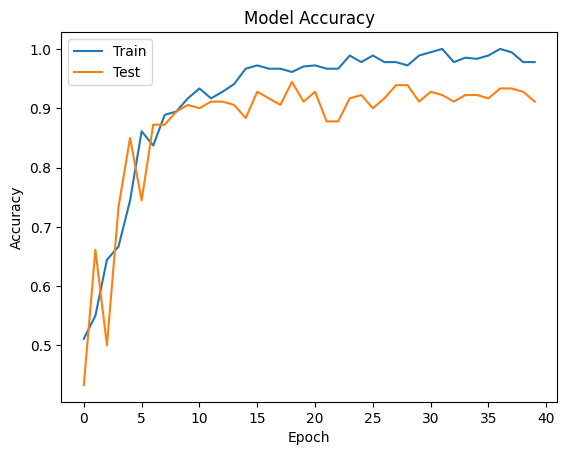

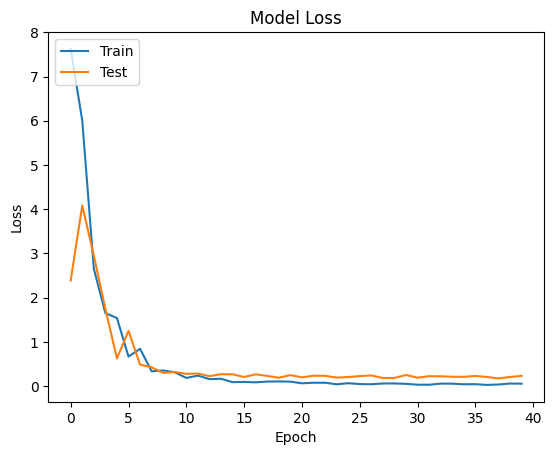

In [28]:
plot_loss_accuracy(history)

#### Model 2: 
Conv 3D Model with 20 frames per video (16, 32, 64, 128 filters conv 3D layers + 256 dense layer + 128 dense layer + image size 120 by 120)¶

In [29]:
# Creazione del modello
model = Sequential()

# Primo layer Conv2D
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(120, 120, 3)))  # Primo layer con 16 filtri
model.add(MaxPooling2D((2, 2)))  # MaxPooling per ridurre le dimensioni

# Secondo layer Conv2D
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Terzo layer Conv2D
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Quarto layer Conv2D
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten per passare ai layer densi
model.add(Flatten())

# Primo layer denso
model.add(Dense(256, activation='relu'))

# Secondo layer denso
model.add(Dense(128, activation='relu'))

# Layer di output con 2 classi (fist e open)
model.add(Dense(2, activation='softmax'))

# Compilazione del modello
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Riepilogo del modello
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 118, 118, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 59, 59, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 57, 57, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 26, 26, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 11, 11, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 950,050 (3.62 MB)

 Trainable params: 950,050 (3.62 MB)

 Non-trainable params: 0 (0.00 B)

The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls it need to make. Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [30]:
# Calcolo dei passi per epoca e di validazione
steps_per_epoch = len(train_doc) // batch_size
validation_steps = len(val_doc) // batch_size

# Definizione dei generatori
train_generator = generate(train_path, train_doc, batch_size)  # usa una sola immagine per batch
val_generator = generate(val_path, val_doc, batch_size)  # usa una sola immagine per batch

# Lista di callback
callbacks_list = model_callbacks("model_Conv2D_2")  


In [31]:
#Tolto il worker = 1
history = model.fit(
    train_generator, 
    steps_per_epoch=steps_per_epoch,  # Numero di passi per epoca per il training
    epochs=num_epochs, 
    verbose=1,        
    callbacks=callbacks_list, 
    validation_data=val_generator,  
    validation_steps=validation_steps,  # Numero di passi per epoca per la validazione
    class_weight=None, 
    initial_epoch=0
)

Epoch 1/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.4667 - loss: 0.6880
Epoch 1: saving model to model_Conv2D_2_2025-06-18_14-11-55/model-00001-0.67805-0.55000-0.65158-0.63333.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 389ms/step - accuracy: 0.4875 - loss: 0.6855 - val_accuracy: 0.6333 - val_loss: 0.6516 - learning_rate: 0.0010
Epoch 2/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.6454 - loss: 0.6649
Epoch 2: saving model to model_Conv2D_2_2025-06-18_14-11-55/model-00002-0.63691-0.71111-0.59983-0.70833.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.6618 - loss: 0.6579 - val_accuracy: 0.7083 - val_loss: 0.5998 - learning_rate: 0.0010
Epoch 3/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.7315 - loss: 0.5703
Epoch 3: saving model to model_Conv2D_2_2025-06-18_14-11-55/model-00003-0.54659-0.76111-0.54612-0.73333.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 213ms/step - accuracy: 0.7389 - loss: 0.5644 - val_accuracy: 0.7333 - val_loss: 0.5461 - learning_rate: 0.0010
Epoch 4/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.7407 - loss: 0.5617
Epoch 4: saving model to model_Conv2D_2_2025-06-18_14-11-55/model-00004-0.53326-0.75556-0.42326-0.80000.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 239ms/step - accuracy: 0.7444 - loss: 0.5546 - val_accuracy: 0.8000 - val_loss: 0.4233 - learning_rate: 0.0010
Epoch 5/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.8139 - loss: 0.3879
Epoch 5: saving model to model_Conv2D_2_2025-06-18_14-11-55/model-00005-0.37531-0.83333-0.39846-0.84167.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 213ms/step - accuracy: 0.8188 - loss: 0.3847 - val_accuracy: 0.8417 - val_loss: 0.3985 - learning_rate: 0.0010
Epoch 6/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.8639 - loss: 0.3069
Epoch 6: saving model to model_Conv2D_2_2025-06-18_14-11-55/model-00006-0.32664-0.86667-0.55164-0.80833.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 245ms/step - accuracy: 0.8646 - loss: 0.3119 - val_accuracy: 0.8083 - val_loss: 0.5516 - learning_rate: 0.0010
Epoch 7/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.7457 - loss: 0.5724
Epoch 7: saving model to model_Conv2D_2_2025-06-18_14-11-55/model-00007-0.41053-0.83704-0.46155-0.80000.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.7685 - loss: 0.5319 - val_accuracy: 0.8000 - val_loss: 0.4616 - learning_rate: 0.0010
Epoch 8/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.8583 - loss: 0.3665
Epoch 8: saving model to model_Conv2D_2_2025-06-18_14-11-55/model-00008-0.36522-0.83333-0.33372-0.86667.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 256ms/step - accuracy: 0.8521 - loss: 0.3662 - val_accuracy: 0.8667 - val_loss: 0.3337 - learning_rate: 0.0010
Epoch 9/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.9213 - loss: 0.2441
Epoch 9: saving model to model_Conv2D_2_2025-06-18_14-11-55/model-00009-0.25145-0.92222-0.33049-0.83333.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 251ms/step - accuracy: 0.9215 - loss: 0.2460 - val_accuracy: 0.8333 - val_loss: 0.3305 - learning_rate: 0.0010
Epoch 10/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.8954 - loss: 0.2590
Epoch 10: saving model to model_Conv2D_2_2025-06-18_14-11-55/model-00010-0.26108-0.89444-0.28899-0.86667.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 230ms/step - accuracy: 0.8951 - loss: 0.2595 - val_accuracy: 0.8667 - val_loss: 0.2890 - learning_rate: 0.0010
Epoch 11/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.8481 - loss: 0.2967
Epoch 11: saving model to model_Conv2D_2_2025-06-18_14-11-55/model-00011-0.31339-0.84444-0.28516-0.89167.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 294ms/step - accuracy: 0.8472 - loss: 0.3009 - val_accuracy: 0.8917 - val_loss: 0.2852 - learning_rate: 0.0010
Epoch 12/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.9222 - loss: 0.2221
Epoch 12: saving model to model_Conv2D_2_2025-06-18_14-11-55/model-00012-0.21136-0.91667-0.29564-0.86667.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step - accuracy: 0.9208 - loss: 0.2194 - val_accuracy: 0.8667 - val_loss: 0.2956 - learning_rate: 0.0010
Epoch 13/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.9278 - loss: 0.2246
Epoch 13: saving model to model_Conv2D_2_2025-06-18_14-11-55/model-00013-0.21372-0.93333-0.25027-0.87500.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 270ms/step - accuracy: 0.9292 - loss: 0.2219 - val_accuracy: 0.8750 - val_loss: 0.2503 - learning_rate: 0.0010
Epoch 14/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - accuracy: 0.9333 - loss: 0.1782
Epoch 14: saving model to model_Conv2D_2_2025-06-18_14-11-55/model-00014-0.16992-0.93333-0.30246-0.88333.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 295ms/step - accuracy: 0.9333 - loss: 0.1761 - val_accuracy: 0.8833 - val_loss: 0.3025 - learning_rate: 0.0010
Epoch 15/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.9056 - loss: 0.2058
Epoch 15: saving model to model_Conv2D_2_2025-06-18_14-11-55/model-00015-0.21454-0.91667-0.27282-0.88333.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 260ms/step - accuracy: 0.9083 - loss: 0.2080 - val_accuracy: 0.8833 - val_loss: 0.2728 - learning_rate: 0.0010
Epoch 16/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.8889 - loss: 0.2221
Epoch 16: saving model to model_Conv2D_2_2025-06-18_14-11-55/model-00016-0.18680-0.91667-0.21293-0.91667.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 244ms/step - accuracy: 0.8958 - loss: 0.2133 - val_accuracy: 0.9167 - val_loss: 0.2129 - learning_rate: 0.0010
Epoch 17/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.9380 - loss: 0.1575
Epoch 17: saving model to model_Conv2D_2_2025-06-18_14-11-55/model-00017-0.17436-0.92222-0.23163-0.90000.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 220ms/step - accuracy: 0.9340 - loss: 0.1617 - val_accuracy: 0.9000 - val_loss: 0.2316 - learning_rate: 0.0010
Epoch 18/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.9407 - loss: 0.1470
Epoch 18: saving model to model_Conv2D_2_2025-06-18_14-11-55/model-00018-0.11016-0.95556-0.24098-0.88333.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 254ms/step - accuracy: 0.9444 - loss: 0.1378 - val_accuracy: 0.8833 - val_loss: 0.2410 - learning_rate: 0.0010
Epoch 19/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.9454 - loss: 0.1223
Epoch 19: saving model to model_Conv2D_2_2025-06-18_14-11-55/model-00019-0.11088-0.96111-0.22830-0.89167.h5



Epoch 19: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 231ms/step - accuracy: 0.9493 - loss: 0.1195 - val_accuracy: 0.8917 - val_loss: 0.2283 - learning_rate: 0.0010
Epoch 20/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.9170 - loss: 0.2828
Epoch 20: saving model to model_Conv2D_2_2025-06-18_14-11-55/model-00020-0.23752-0.92593-0.21066-0.91667.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.9192 - loss: 0.2715 - val_accuracy: 0.9167 - val_loss: 0.2107 - learning_rate: 1.0000e-04
Epoch 21/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.9556 - loss: 0.1130
Epoch 21: saving model to model_Conv2D_2_2025-06-18_14-11-55/model-00021-0.12397-0.95000-0.21109-0.91667.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step - accuracy: 0.9542 - loss: 0.1157 - val_accuracy: 0.9167 - val_loss: 0.2111 - learning_rate: 1.0000e-04
Epoch 22/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.9713 - loss: 0.0876
Epoch 22: saving model to model_Conv2D_2_2025-06-18_14-11-55/model-00022-0.08174-0.97222-0.21637-0.90000.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 236ms/step - accuracy: 0.9715 - loss: 0.0862 - val_accuracy: 0.9000 - val_loss: 0.2164 - learning_rate: 1.0000e-04
Epoch 23/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.9296 - loss: 0.1770
Epoch 23: saving model to model_Conv2D_2_2025-06-18_14-11-55/model-00023-0.20045-0.92222-0.20706-0.92500.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 270ms/step - accuracy: 0.9278 - loss: 0.1829 - val_accuracy: 0.9250 - val_loss: 0.2071 - learning_rate: 1.0000e-04
Epoch 24/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.9324 - loss: 0.1330
Epoch 24: saving model to model_Conv2D_2_2025-06-18_14-11-55/model-00024-0.10156-0.95556-0.20458-0.90000.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 237ms/step - accuracy: 0.9382 - loss: 0.1251 - val_accuracy: 0.9000 - val_loss: 0.2046 - learning_rate: 1.0000e-04
Epoch 25/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.9880 - loss: 0.0849
Epoch 25: saving model to model_Conv2D_2_2025-06-18_14-11-55/model-00025-0.10926-0.97222-0.21199-0.90833.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 237ms/step - accuracy: 0.9840 - loss: 0.0910 - val_accuracy: 0.9083 - val_loss: 0.2120 - learning_rate: 1.0000e-04
Epoch 26/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.9306 - loss: 0.1678
Epoch 26: saving model to model_Conv2D_2_2025-06-18_14-11-55/model-00026-0.13172-0.95000-0.20103-0.91667.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 214ms/step - accuracy: 0.9354 - loss: 0.1588 - val_accuracy: 0.9167 - val_loss: 0.2010 - learning_rate: 1.0000e-04
Epoch 27/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.9626 - loss: 0.0933
Epoch 27: saving model to model_Conv2D_2_2025-06-18_14-11-55/model-00027-0.07251-0.97778-0.20539-0.91667.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step - accuracy: 0.9664 - loss: 0.0881 - val_accuracy: 0.9167 - val_loss: 0.2054 - learning_rate: 1.0000e-04
Epoch 28/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.9019 - loss: 0.2045
Epoch 28: saving model to model_Conv2D_2_2025-06-18_14-11-55/model-00028-0.17141-0.92222-0.21675-0.90833.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 326ms/step - accuracy: 0.9069 - loss: 0.1962 - val_accuracy: 0.9083 - val_loss: 0.2168 - learning_rate: 1.0000e-04
Epoch 29/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.9639 - loss: 0.1000
Epoch 29: saving model to model_Conv2D_2_2025-06-18_14-11-55/model-00029-0.09614-0.96667-0.20467-0.92500.h5



Epoch 29: ReduceLROnPlateau reducing learning rate to 0.0001.
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.9646 - loss: 0.0990 - val_accuracy: 0.9250 - val_loss: 0.2047 - learning_rate: 1.0000e-04
Epoch 30/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.9787 - loss: 0.0690
Epoch 30: saving model to model_Conv2D_2_2025-06-18_14-11-55/model-00030-0.10704-0.96111-0.20302-0.91667.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 202ms/step - accuracy: 0.9743 - loss: 0.0785 - val_accuracy: 0.9167 - val_loss: 0.2030 - learning_rate: 1.0000e-04
Epoch 31/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9630 - loss: 0.1019
Epoch 31: saving model to model_Conv2D_2_2025-06-18_14-11-55/model-00031-0.11655-0.95556-0.20257-0.90833.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step - accuracy: 0.9611 - loss: 0.1055 - val_accuracy: 0.9083 - val_loss: 0.2026 - learning_rate: 1.0000e-04
Epoch 32/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.9852 - loss: 0.0785
Epoch 32: saving model to model_Conv2D_2_2025-06-18_14-11-55/model-00032-0.06692-0.98889-0.19974-0.91667.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 266ms/step - accuracy: 0.9861 - loss: 0.0756 - val_accuracy: 0.9167 - val_loss: 0.1997 - learning_rate: 1.0000e-04
Epoch 33/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9574 - loss: 0.1014
Epoch 33: saving model to model_Conv2D_2_2025-06-18_14-11-55/model-00033-0.10979-0.95556-0.20045-0.91667.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 276ms/step - accuracy: 0.9569 - loss: 0.1035 - val_accuracy: 0.9167 - val_loss: 0.2004 - learning_rate: 1.0000e-04
Epoch 34/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.8775 - loss: 0.2032
Epoch 34: saving model to model_Conv2D_2_2025-06-18_14-11-55/model-00034-0.12631-0.92593-0.20352-0.90000.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 239ms/step - accuracy: 0.8896 - loss: 0.1840 - val_accuracy: 0.9000 - val_loss: 0.2035 - learning_rate: 1.0000e-04
Epoch 35/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.9741 - loss: 0.0925
Epoch 35: saving model to model_Conv2D_2_2025-06-18_14-11-55/model-00035-0.08862-0.97222-0.20895-0.90000.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 250ms/step - accuracy: 0.9736 - loss: 0.0915 - val_accuracy: 0.9000 - val_loss: 0.2090 - learning_rate: 1.0000e-04
Epoch 36/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.9537 - loss: 0.1530
Epoch 36: saving model to model_Conv2D_2_2025-06-18_14-11-55/model-00036-0.13928-0.96111-0.20000-0.91667.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 265ms/step - accuracy: 0.9556 - loss: 0.1496 - val_accuracy: 0.9167 - val_loss: 0.2000 - learning_rate: 1.0000e-04
Epoch 37/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.9593 - loss: 0.1323
Epoch 37: saving model to model_Conv2D_2_2025-06-18_14-11-55/model-00037-0.11508-0.96111-0.20665-0.91667.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.9597 - loss: 0.1280 - val_accuracy: 0.9167 - val_loss: 0.2066 - learning_rate: 1.0000e-04
Epoch 38/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.9380 - loss: 0.1400
Epoch 38: saving model to model_Conv2D_2_2025-06-18_14-11-55/model-00038-0.11477-0.95556-0.20275-0.91667.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 223ms/step - accuracy: 0.9424 - loss: 0.1337 - val_accuracy: 0.9167 - val_loss: 0.2027 - learning_rate: 1.0000e-04
Epoch 39/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.9657 - loss: 0.0844
Epoch 39: saving model to model_Conv2D_2_2025-06-18_14-11-55/model-00039-0.07022-0.97222-0.19337-0.92500.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 302ms/step - accuracy: 0.9674 - loss: 0.0809 - val_accuracy: 0.9250 - val_loss: 0.1934 - learning_rate: 1.0000e-04
Epoch 40/40
2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.9500 - loss: 0.0892
Epoch 40: saving model to model_Conv2D_2_2025-06-18_14-11-55/model-00040-0.06954-0.97037-0.18862-0.92500.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.9602 - loss: 0.0794 - val_accuracy: 0.9250 - val_loss: 0.1886 - learning_rate: 1.0000e-04


Chiavi disponibili in history: dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])


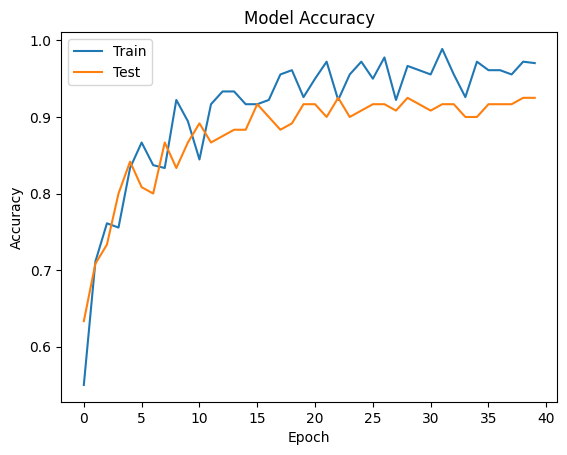

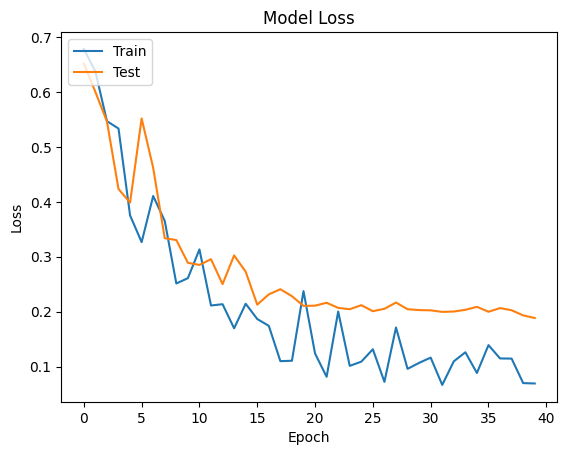

In [32]:
plot_loss_accuracy(history)

#### Model 3: 
Conv 2D Model with (32, 64, 128, 256) filters conv 2D layers + 128 dense layer + 128 dense layer + image size 120 by 120)

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Creazione del modello
model = Sequential()

# Primo layer Conv2D
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(120, 120, 3)))  # Primo layer con 16 filtri
model.add(MaxPooling2D((2, 2)))  # MaxPooling per ridurre le dimensioni

# Secondo layer Conv2D
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Terzo layer Conv2D
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Quarto layer Conv2D
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten per passare ai layer densi
model.add(Flatten())

# Primo layer denso
model.add(Dense(128, activation='relu'))

# Secondo layer denso
model.add(Dense(128, activation='relu'))

# Layer di output con 2 classi (fist e open)
model.add(Dense(2, activation='softmax'))

# Compilazione del modello
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Riepilogo del modello
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 118, 118, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 59, 59, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 57, 57, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 26, 26, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 13, 13, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 11, 11, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       819,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,224,514 (4.67 MB)

 Trainable params: 1,224,514 (4.67 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
# Calcolo dei passi per epoca e di validazione
steps_per_epoch = len(train_doc) // batch_size
validation_steps = len(val_doc) // batch_size

# Definizione dei generatori
train_generator = generate(train_path, train_doc, batch_size)  # usa una sola immagine per batch
val_generator = generate(val_path, val_doc, batch_size)  # usa una sola immagine per batch

# Lista di callback
callbacks_list = model_callbacks("model_Conv2D_2")  # Puoi cambiarlo con un nome diverso per il tuo modello


In [35]:
# Tolto anche qui il worker = 1
history = model.fit(
    train_generator, 
    steps_per_epoch=steps_per_epoch,  # Numero di passi per epoca per il training
    epochs=num_epochs, 
    verbose=1,        
    callbacks=callbacks_list, 
    validation_data=val_generator,  
    validation_steps=validation_steps,  # Numero di passi per epoca per la validazione
    class_weight=None, 
    initial_epoch=0
)

Epoch 1/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.6935 - loss: 0.6879
Epoch 1: saving model to model_Conv2D_2_2025-06-18_14-12-21/model-00001-0.68796-0.67222-0.67912-0.65833.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 482ms/step - accuracy: 0.6882 - loss: 0.6879 - val_accuracy: 0.6583 - val_loss: 0.6791 - learning_rate: 0.0010
Epoch 2/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - accuracy: 0.6861 - loss: 0.6734
Epoch 2: saving model to model_Conv2D_2_2025-06-18_14-12-21/model-00002-0.66159-0.73333-0.67440-0.60000.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 358ms/step - accuracy: 0.6979 - loss: 0.6704 - val_accuracy: 0.6000 - val_loss: 0.6744 - learning_rate: 0.0010
Epoch 3/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.6259 - loss: 0.6527
Epoch 3: saving model to model_Conv2D_2_2025-06-18_14-12-21/model-00003-0.63278-0.66111-0.59159-0.74167.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 313ms/step - accuracy: 0.6347 - loss: 0.6477 - val_accuracy: 0.7417 - val_loss: 0.5916 - learning_rate: 0.0010
Epoch 4/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.7315 - loss: 0.5977
Epoch 4: saving model to model_Conv2D_2_2025-06-18_14-12-21/model-00004-0.57961-0.74444-0.51675-0.74167.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 309ms/step - accuracy: 0.7347 - loss: 0.5932 - val_accuracy: 0.7417 - val_loss: 0.5167 - learning_rate: 0.0010
Epoch 5/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.8074 - loss: 0.4628
Epoch 5: saving model to model_Conv2D_2_2025-06-18_14-12-21/model-00005-0.44784-0.82222-0.39057-0.83333.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 285ms/step - accuracy: 0.8111 - loss: 0.4590 - val_accuracy: 0.8333 - val_loss: 0.3906 - learning_rate: 0.0010
Epoch 6/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.8528 - loss: 0.3675
Epoch 6: saving model to model_Conv2D_2_2025-06-18_14-12-21/model-00006-0.39990-0.83333-0.37267-0.84167.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 312ms/step - accuracy: 0.8479 - loss: 0.3756 - val_accuracy: 0.8417 - val_loss: 0.3727 - learning_rate: 0.0010
Epoch 7/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.8741 - loss: 0.2695
Epoch 7: saving model to model_Conv2D_2_2025-06-18_14-12-21/model-00007-0.25193-0.88889-0.41333-0.82500.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 284ms/step - accuracy: 0.8778 - loss: 0.2651 - val_accuracy: 0.8250 - val_loss: 0.4133 - learning_rate: 0.0010
Epoch 8/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.8157 - loss: 0.3917
Epoch 8: saving model to model_Conv2D_2_2025-06-18_14-12-21/model-00008-0.35715-0.83889-0.30824-0.85000.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 302ms/step - accuracy: 0.8215 - loss: 0.3831 - val_accuracy: 0.8500 - val_loss: 0.3082 - learning_rate: 0.0010
Epoch 9/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.8981 - loss: 0.2548
Epoch 9: saving model to model_Conv2D_2_2025-06-18_14-12-21/model-00009-0.22520-0.91111-0.28513-0.85833.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 300ms/step - accuracy: 0.9014 - loss: 0.2474 - val_accuracy: 0.8583 - val_loss: 0.2851 - learning_rate: 0.0010
Epoch 10/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.8213 - loss: 0.3730
Epoch 10: saving model to model_Conv2D_2_2025-06-18_14-12-21/model-00010-0.36950-0.83889-0.34537-0.85000.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 280ms/step - accuracy: 0.8257 - loss: 0.3721 - val_accuracy: 0.8500 - val_loss: 0.3454 - learning_rate: 0.0010
Epoch 11/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.8731 - loss: 0.2536
Epoch 11: saving model to model_Conv2D_2_2025-06-18_14-12-21/model-00011-0.26736-0.87778-0.28281-0.90833.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 312ms/step - accuracy: 0.8743 - loss: 0.2571 - val_accuracy: 0.9083 - val_loss: 0.2828 - learning_rate: 0.0010
Epoch 12/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.9296 - loss: 0.2042
Epoch 12: saving model to model_Conv2D_2_2025-06-18_14-12-21/model-00012-0.22558-0.90556-0.27579-0.88333.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 328ms/step - accuracy: 0.9236 - loss: 0.2095 - val_accuracy: 0.8833 - val_loss: 0.2758 - learning_rate: 0.0010
Epoch 13/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.9204 - loss: 0.2802
Epoch 13: saving model to model_Conv2D_2_2025-06-18_14-12-21/model-00013-0.24425-0.92778-0.23541-0.89167.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 338ms/step - accuracy: 0.9222 - loss: 0.2712 - val_accuracy: 0.8917 - val_loss: 0.2354 - learning_rate: 0.0010
Epoch 14/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.9580 - loss: 0.1314
Epoch 14: saving model to model_Conv2D_2_2025-06-18_14-12-21/model-00014-0.15237-0.94074-0.24532-0.89167.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 352ms/step - accuracy: 0.9537 - loss: 0.1367 - val_accuracy: 0.8917 - val_loss: 0.2453 - learning_rate: 0.0010
Epoch 15/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.9269 - loss: 0.1813
Epoch 15: saving model to model_Conv2D_2_2025-06-18_14-12-21/model-00015-0.19111-0.92222-0.25781-0.88333.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 308ms/step - accuracy: 0.9257 - loss: 0.1838 - val_accuracy: 0.8833 - val_loss: 0.2578 - learning_rate: 0.0010
Epoch 16/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.8963 - loss: 0.2784
Epoch 16: saving model to model_Conv2D_2_2025-06-18_14-12-21/model-00016-0.25064-0.90556-0.28092-0.88333.h5



Epoch 16: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 299ms/step - accuracy: 0.8986 - loss: 0.2715 - val_accuracy: 0.8833 - val_loss: 0.2809 - learning_rate: 0.0010
Epoch 17/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.9037 - loss: 0.2386
Epoch 17: saving model to model_Conv2D_2_2025-06-18_14-12-21/model-00017-0.22563-0.91111-0.24414-0.90000.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 299ms/step - accuracy: 0.9056 - loss: 0.2354 - val_accuracy: 0.9000 - val_loss: 0.2441 - learning_rate: 1.0000e-04
Epoch 18/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.9778 - loss: 0.1096
Epoch 18: saving model to model_Conv2D_2_2025-06-18_14-12-21/model-00018-0.11985-0.96667-0.21382-0.90833.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 298ms/step - accuracy: 0.9750 - loss: 0.1122 - val_accuracy: 0.9083 - val_loss: 0.2138 - learning_rate: 1.0000e-04
Epoch 19/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.9074 - loss: 0.2562
Epoch 19: saving model to model_Conv2D_2_2025-06-18_14-12-21/model-00019-0.20592-0.92222-0.21378-0.87500.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step - accuracy: 0.9111 - loss: 0.2436 - val_accuracy: 0.8750 - val_loss: 0.2138 - learning_rate: 1.0000e-04
Epoch 20/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.9358 - loss: 0.1452
Epoch 20: saving model to model_Conv2D_2_2025-06-18_14-12-21/model-00020-0.13910-0.94074-0.22474-0.87500.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 238ms/step - accuracy: 0.9370 - loss: 0.1437 - val_accuracy: 0.8750 - val_loss: 0.2247 - learning_rate: 1.0000e-04
Epoch 21/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.8778 - loss: 0.2245
Epoch 21: saving model to model_Conv2D_2_2025-06-18_14-12-21/model-00021-0.18439-0.90000-0.20844-0.88333.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 309ms/step - accuracy: 0.8833 - loss: 0.2145 - val_accuracy: 0.8833 - val_loss: 0.2084 - learning_rate: 1.0000e-04
Epoch 22/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.9657 - loss: 0.1265
Epoch 22: saving model to model_Conv2D_2_2025-06-18_14-12-21/model-00022-0.12334-0.95556-0.19668-0.91667.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 292ms/step - accuracy: 0.9632 - loss: 0.1257 - val_accuracy: 0.9167 - val_loss: 0.1967 - learning_rate: 1.0000e-04
Epoch 23/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9593 - loss: 0.1153
Epoch 23: saving model to model_Conv2D_2_2025-06-18_14-12-21/model-00023-0.14040-0.94444-0.19936-0.91667.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 322ms/step - accuracy: 0.9556 - loss: 0.1216 - val_accuracy: 0.9167 - val_loss: 0.1994 - learning_rate: 1.0000e-04
Epoch 24/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.9639 - loss: 0.0843
Epoch 24: saving model to model_Conv2D_2_2025-06-18_14-12-21/model-00024-0.08564-0.96667-0.21139-0.90833.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 293ms/step - accuracy: 0.9646 - loss: 0.0846 - val_accuracy: 0.9083 - val_loss: 0.2114 - learning_rate: 1.0000e-04
Epoch 25/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.8759 - loss: 0.2616
Epoch 25: saving model to model_Conv2D_2_2025-06-18_14-12-21/model-00025-0.28085-0.86111-0.20501-0.90833.h5



Epoch 25: ReduceLROnPlateau reducing learning rate to 0.0001.
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 315ms/step - accuracy: 0.8722 - loss: 0.2664 - val_accuracy: 0.9083 - val_loss: 0.2050 - learning_rate: 1.0000e-04
Epoch 26/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.9528 - loss: 0.1691
Epoch 26: saving model to model_Conv2D_2_2025-06-18_14-12-21/model-00026-0.15883-0.95000-0.18261-0.92500.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 296ms/step - accuracy: 0.9521 - loss: 0.1665 - val_accuracy: 0.9250 - val_loss: 0.1826 - learning_rate: 1.0000e-04
Epoch 27/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.9727 - loss: 0.0987
Epoch 27: saving model to model_Conv2D_2_2025-06-18_14-12-21/model-00027-0.14056-0.94815-0.18446-0.90000.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 248ms/step - accuracy: 0.9666 - loss: 0.1092 - val_accuracy: 0.9000 - val_loss: 0.1845 - learning_rate: 1.0000e-04
Epoch 28/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.9148 - loss: 0.1667
Epoch 28: saving model to model_Conv2D_2_2025-06-18_14-12-21/model-00028-0.16850-0.92778-0.17841-0.92500.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 303ms/step - accuracy: 0.9181 - loss: 0.1672 - val_accuracy: 0.9250 - val_loss: 0.1784 - learning_rate: 1.0000e-04
Epoch 29/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.9750 - loss: 0.1020
Epoch 29: saving model to model_Conv2D_2_2025-06-18_14-12-21/model-00029-0.13146-0.95000-0.18428-0.91667.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 299ms/step - accuracy: 0.9688 - loss: 0.1093 - val_accuracy: 0.9167 - val_loss: 0.1843 - learning_rate: 1.0000e-04
Epoch 30/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.9241 - loss: 0.1783
Epoch 30: saving model to model_Conv2D_2_2025-06-18_14-12-21/model-00030-0.13867-0.93889-0.17845-0.92500.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 306ms/step - accuracy: 0.9278 - loss: 0.1684 - val_accuracy: 0.9250 - val_loss: 0.1785 - learning_rate: 1.0000e-04
Epoch 31/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.9713 - loss: 0.0917
Epoch 31: saving model to model_Conv2D_2_2025-06-18_14-12-21/model-00031-0.13651-0.95556-0.17708-0.92500.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 302ms/step - accuracy: 0.9674 - loss: 0.1029 - val_accuracy: 0.9250 - val_loss: 0.1771 - learning_rate: 1.0000e-04
Epoch 32/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.9546 - loss: 0.1128
Epoch 32: saving model to model_Conv2D_2_2025-06-18_14-12-21/model-00032-0.14216-0.93889-0.16900-0.92500.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 292ms/step - accuracy: 0.9507 - loss: 0.1201 - val_accuracy: 0.9250 - val_loss: 0.1690 - learning_rate: 1.0000e-04
Epoch 33/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.9657 - loss: 0.1101
Epoch 33: saving model to model_Conv2D_2_2025-06-18_14-12-21/model-00033-0.09156-0.97222-0.17089-0.90833.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 300ms/step - accuracy: 0.9674 - loss: 0.1054 - val_accuracy: 0.9083 - val_loss: 0.1709 - learning_rate: 1.0000e-04
Epoch 34/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.9511 - loss: 0.1077
Epoch 34: saving model to model_Conv2D_2_2025-06-18_14-12-21/model-00034-0.12071-0.93333-0.16105-0.92500.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 299ms/step - accuracy: 0.9467 - loss: 0.1109 - val_accuracy: 0.9250 - val_loss: 0.1610 - learning_rate: 1.0000e-04
Epoch 35/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.9861 - loss: 0.0868
Epoch 35: saving model to model_Conv2D_2_2025-06-18_14-12-21/model-00035-0.12131-0.96667-0.16582-0.92500.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 311ms/step - accuracy: 0.9812 - loss: 0.0954 - val_accuracy: 0.9250 - val_loss: 0.1658 - learning_rate: 1.0000e-04
Epoch 36/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.9565 - loss: 0.1228
Epoch 36: saving model to model_Conv2D_2_2025-06-18_14-12-21/model-00036-0.12885-0.94444-0.15475-0.92500.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 295ms/step - accuracy: 0.9535 - loss: 0.1243 - val_accuracy: 0.9250 - val_loss: 0.1548 - learning_rate: 1.0000e-04
Epoch 37/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.9370 - loss: 0.1444
Epoch 37: saving model to model_Conv2D_2_2025-06-18_14-12-21/model-00037-0.13858-0.94444-0.15189-0.93333.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 304ms/step - accuracy: 0.9389 - loss: 0.1429 - val_accuracy: 0.9333 - val_loss: 0.1519 - learning_rate: 1.0000e-04
Epoch 38/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.9639 - loss: 0.0901
Epoch 38: saving model to model_Conv2D_2_2025-06-18_14-12-21/model-00038-0.10229-0.95000-0.14716-0.92500.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 303ms/step - accuracy: 0.9604 - loss: 0.0931 - val_accuracy: 0.9250 - val_loss: 0.1472 - learning_rate: 1.0000e-04
Epoch 39/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.9602 - loss: 0.1409
Epoch 39: saving model to model_Conv2D_2_2025-06-18_14-12-21/model-00039-0.13242-0.95556-0.16370-0.93333.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 324ms/step - accuracy: 0.9590 - loss: 0.1388 - val_accuracy: 0.9333 - val_loss: 0.1637 - learning_rate: 1.0000e-04
Epoch 40/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.9361 - loss: 0.1387
Epoch 40: saving model to model_Conv2D_2_2025-06-18_14-12-21/model-00040-0.13913-0.93333-0.15076-0.92500.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 235ms/step - accuracy: 0.9354 - loss: 0.1388 - val_accuracy: 0.9250 - val_loss: 0.1508 - learning_rate: 1.0000e-04


Chiavi disponibili in history: dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])


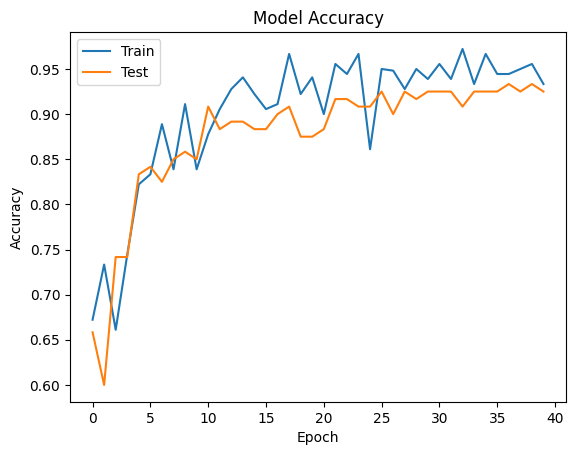

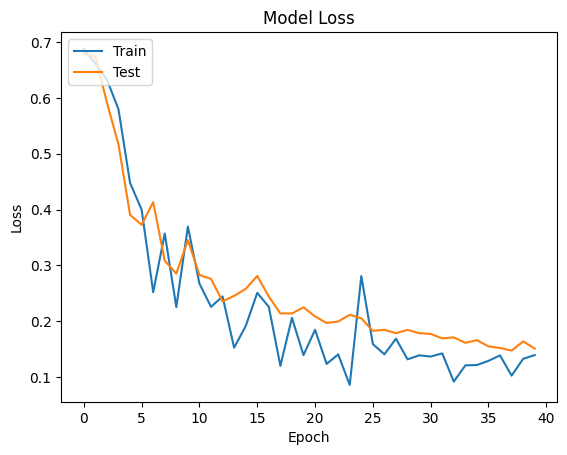

In [36]:
plot_loss_accuracy(history)

#### Model 4: 
Conv 2D Model with (32, 64, 128, 256) filters conv 2D layers + 128 dense layer + 128 dense layer + image size 120 by 120) with batch normalization

In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

from tensorflow.keras.callbacks import ReduceLROnPlateau # Per ridurre il learning rate

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)


model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(120, 120, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),

    Dense(128, activation='relu'),
    Dropout(0.3),

    Dense(128, activation='relu'),
    Dropout(0.3),

    Dense(2, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 118, 118, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 118, 118, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 59, 59, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 57, 57, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 57, 57, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 26, 26, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 26, 26, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 13, 13, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 11, 11, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 11, 11, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │       819,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,226,434 (4.68 MB)

 Trainable params: 1,225,474 (4.67 MB)

 Non-trainable params: 960 (3.75 KB)

In [38]:
# Calcolo dei passi per epoca e di validazione
steps_per_epoch = len(train_doc) // batch_size
validation_steps = len(val_doc) // batch_size

# Definizione dei generatori
train_generator = generate(train_path, train_doc, batch_size)  # usa una sola immagine per batch
val_generator = generate(val_path, val_doc, batch_size)  # usa una sola immagine per batch

# Lista di callback
callbacks_list = model_callbacks("model_Conv2D_2")  # Puoi cambiarlo con un nome diverso per il tuo modello

In [39]:
history = model.fit(
    train_generator, 
    steps_per_epoch=steps_per_epoch,  # Numero di passi per epoca per il training
    epochs=40, 
    verbose=1,        
    callbacks=[callbacks_list, reduce_lr], 
    validation_data=val_generator,  
    validation_steps=validation_steps,  # Numero di passi per epoca per la validazione
    class_weight=None, 
    initial_epoch=0
)

Epoch 1/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.6352 - loss: 1.3999
Epoch 1: saving model to model_Conv2D_2_2025-06-18_14-12-55/model-00001-1.05207-0.73889-0.70681-0.37500.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 610ms/step - accuracy: 0.6611 - loss: 1.3130 - val_accuracy: 0.3750 - val_loss: 0.7068 - learning_rate: 0.0010
Epoch 2/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.8481 - loss: 0.5300
Epoch 2: saving model to model_Conv2D_2_2025-06-18_14-12-55/model-00002-0.54654-0.84444-0.72845-0.40000.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 404ms/step - accuracy: 0.8472 - loss: 0.5341 - val_accuracy: 0.4000 - val_loss: 0.7285 - learning_rate: 0.0010
Epoch 3/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - accuracy: 0.8741 - loss: 0.6066
Epoch 3: saving model to model_Conv2D_2_2025-06-18_14-12-55/model-00003-0.44307-0.88889-0.67696-0.44167.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 415ms/step - accuracy: 0.8778 - loss: 0.5658 - val_accuracy: 0.4417 - val_loss: 0.6770 - learning_rate: 0.0010
Epoch 4/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - accuracy: 0.9343 - loss: 0.2395
Epoch 4: saving model to model_Conv2D_2_2025-06-18_14-12-55/model-00004-0.40635-0.91111-0.66818-0.47500.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 413ms/step - accuracy: 0.9285 - loss: 0.2812 - val_accuracy: 0.4750 - val_loss: 0.6682 - learning_rate: 0.0010
Epoch 5/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.8315 - loss: 0.5513
Epoch 5: saving model to model_Conv2D_2_2025-06-18_14-12-55/model-00005-0.51601-0.82778-0.79956-0.46667.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 401ms/step - accuracy: 0.8306 - loss: 0.5425 - val_accuracy: 0.4667 - val_loss: 0.7996 - learning_rate: 0.0010
Epoch 6/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.8861 - loss: 0.5653
Epoch 6: saving model to model_Conv2D_2_2025-06-18_14-12-55/model-00006-0.49064-0.90000-0.82567-0.56667.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 396ms/step - accuracy: 0.8896 - loss: 0.5466 - val_accuracy: 0.5667 - val_loss: 0.8257 - learning_rate: 0.0010
Epoch 7/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.8411 - loss: 0.5242
Epoch 7: saving model to model_Conv2D_2_2025-06-18_14-12-55/model-00007-0.42585-0.86667-0.69290-0.66667.h5



Epoch 7: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 7: ReduceLROnPlateau reducing learning rate to 5.0000002374872565e-05.
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 321ms/step - accuracy: 0.8475 - loss: 0.4996 - val_accuracy: 0.6667 - val_loss: 0.6929 - learning_rate: 1.0000e-04
Epoch 8/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 0.9185 - loss: 0.7102
Epoch 8: saving model to model_Conv2D_2_2025-06-18_14-12-55/model-00008-0.62897-0.92222-0.52419-0.75833.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 391ms/step - accuracy: 0.9194 - loss: 0.6899 - val_accuracy: 0.7583 - val_loss: 0.5242 - learning_rate: 5.0000e-05
Epoch 9/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.8972 - loss: 0.5524
Epoch 9: saving model to model_Conv2D_2_2025-06-18_14-12-55/model-00009-0.50007-0.90000-0.41133-0.76667.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 398ms/step - accuracy: 0.8979 - loss: 0.5393 - val_accuracy: 0.7667 - val_loss: 0.4113 - learning_rate: 5.0000e-05
Epoch 10/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - accuracy: 0.9296 - loss: 0.2883
Epoch 10: saving model to model_Conv2D_2_2025-06-18_14-12-55/model-00010-0.28673-0.92222-0.34676-0.87500.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 408ms/step - accuracy: 0.9278 - loss: 0.2879 - val_accuracy: 0.8750 - val_loss: 0.3468 - learning_rate: 5.0000e-05
Epoch 11/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - accuracy: 0.9343 - loss: 0.3175
Epoch 11: saving model to model_Conv2D_2_2025-06-18_14-12-55/model-00011-0.26606-0.92778-0.38838-0.80833.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 410ms/step - accuracy: 0.9326 - loss: 0.3047 - val_accuracy: 0.8083 - val_loss: 0.3884 - learning_rate: 5.0000e-05
Epoch 12/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.9241 - loss: 0.4063
Epoch 12: saving model to model_Conv2D_2_2025-06-18_14-12-55/model-00012-0.32737-0.93889-0.48544-0.75000.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 405ms/step - accuracy: 0.9278 - loss: 0.3866 - val_accuracy: 0.7500 - val_loss: 0.4854 - learning_rate: 5.0000e-05
Epoch 13/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.8880 - loss: 0.3081
Epoch 13: saving model to model_Conv2D_2_2025-06-18_14-12-55/model-00013-0.26992-0.90556-0.57852-0.66667.h5



Epoch 13: ReduceLROnPlateau reducing learning rate to 2.5000001187436283e-05.
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 385ms/step - accuracy: 0.8924 - loss: 0.2985 - val_accuracy: 0.6667 - val_loss: 0.5785 - learning_rate: 5.0000e-05
Epoch 14/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - accuracy: 0.9664 - loss: 0.1628
Epoch 14: saving model to model_Conv2D_2_2025-06-18_14-12-55/model-00014-0.31719-0.92593-0.67158-0.63333.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 437ms/step - accuracy: 0.9563 - loss: 0.2014 - val_accuracy: 0.6333 - val_loss: 0.6716 - learning_rate: 2.5000e-05
Epoch 15/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - accuracy: 0.9167 - loss: 0.2374
Epoch 15: saving model to model_Conv2D_2_2025-06-18_14-12-55/model-00015-0.22969-0.91667-0.76343-0.63333.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 400ms/step - accuracy: 0.9167 - loss: 0.2354 - val_accuracy: 0.6333 - val_loss: 0.7634 - learning_rate: 2.5000e-05
Epoch 16/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.9269 - loss: 0.2652
Epoch 16: saving model to model_Conv2D_2_2025-06-18_14-12-55/model-00016-0.32854-0.92222-0.83998-0.63333.h5



Epoch 16: ReduceLROnPlateau reducing learning rate to 1.2500000593718141e-05.
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 432ms/step - accuracy: 0.9257 - loss: 0.2811 - val_accuracy: 0.6333 - val_loss: 0.8400 - learning_rate: 2.5000e-05
Epoch 17/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.9500 - loss: 0.1807
Epoch 17: saving model to model_Conv2D_2_2025-06-18_14-12-55/model-00017-0.17285-0.95000-0.90735-0.63333.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 480ms/step - accuracy: 0.9500 - loss: 0.1788 - val_accuracy: 0.6333 - val_loss: 0.9074 - learning_rate: 1.2500e-05
Epoch 18/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - accuracy: 0.9528 - loss: 0.2294
Epoch 18: saving model to model_Conv2D_2_2025-06-18_14-12-55/model-00018-0.22151-0.95000-0.95308-0.63333.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 594ms/step - accuracy: 0.9521 - loss: 0.2274 - val_accuracy: 0.6333 - val_loss: 0.9531 - learning_rate: 1.2500e-05
Epoch 19/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - accuracy: 0.9852 - loss: 0.1255
Epoch 19: saving model to model_Conv2D_2_2025-06-18_14-12-55/model-00019-0.19701-0.97222-0.99842-0.63333.h5



Epoch 19: ReduceLROnPlateau reducing learning rate to 6.250000296859071e-06.
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step - accuracy: 0.9819 - loss: 0.1434 - val_accuracy: 0.6333 - val_loss: 0.9984 - learning_rate: 1.2500e-05
Epoch 20/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.9549 - loss: 0.1055
Epoch 20: saving model to model_Conv2D_2_2025-06-18_14-12-55/model-00020-0.10756-0.94815-1.03180-0.63333.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 406ms/step - accuracy: 0.9532 - loss: 0.1060 - val_accuracy: 0.6333 - val_loss: 1.0318 - learning_rate: 6.2500e-06
Epoch 21/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9648 - loss: 0.1318
Epoch 21: saving model to model_Conv2D_2_2025-06-18_14-12-55/model-00021-0.20852-0.96111-1.05047-0.63333.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 463ms/step - accuracy: 0.9639 - loss: 0.1510 - val_accuracy: 0.6333 - val_loss: 1.0505 - learning_rate: 6.2500e-06
Epoch 22/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.9083 - loss: 0.2707
Epoch 22: saving model to model_Conv2D_2_2025-06-18_14-12-55/model-00022-0.23628-0.90000-1.06328-0.63333.h5



Epoch 22: ReduceLROnPlateau reducing learning rate to 3.1250001484295353e-06.
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 429ms/step - accuracy: 0.9062 - loss: 0.2621 - val_accuracy: 0.6333 - val_loss: 1.0633 - learning_rate: 6.2500e-06
Epoch 23/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - accuracy: 0.9361 - loss: 0.3057
Epoch 23: saving model to model_Conv2D_2_2025-06-18_14-12-55/model-00023-0.29456-0.93333-1.07387-0.63333.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 411ms/step - accuracy: 0.9354 - loss: 0.3029 - val_accuracy: 0.6333 - val_loss: 1.0739 - learning_rate: 3.1250e-06
Epoch 24/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 0.9593 - loss: 0.1891
Epoch 24: saving model to model_Conv2D_2_2025-06-18_14-12-55/model-00024-0.17122-0.96111-1.08156-0.63333.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 407ms/step - accuracy: 0.9597 - loss: 0.1847 - val_accuracy: 0.6333 - val_loss: 1.0816 - learning_rate: 3.1250e-06
Epoch 25/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.9370 - loss: 0.1715
Epoch 25: saving model to model_Conv2D_2_2025-06-18_14-12-55/model-00025-0.21426-0.94444-1.08368-0.63333.h5



Epoch 25: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-06.
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 398ms/step - accuracy: 0.9389 - loss: 0.1822 - val_accuracy: 0.6333 - val_loss: 1.0837 - learning_rate: 3.1250e-06
Epoch 26/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - accuracy: 0.9500 - loss: 0.1381
Epoch 26: saving model to model_Conv2D_2_2025-06-18_14-12-55/model-00026-0.11730-0.95000-1.08670-0.63333.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 438ms/step - accuracy: 0.9500 - loss: 0.1329 - val_accuracy: 0.6333 - val_loss: 1.0867 - learning_rate: 1.5625e-06
Epoch 27/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.9577 - loss: 0.1064
Epoch 27: saving model to model_Conv2D_2_2025-06-18_14-12-55/model-00027-0.09885-0.96296-1.08508-0.63333.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 310ms/step - accuracy: 0.9590 - loss: 0.1045 - val_accuracy: 0.6333 - val_loss: 1.0851 - learning_rate: 1.5625e-06
Epoch 28/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.9435 - loss: 0.2317
Epoch 28: saving model to model_Conv2D_2_2025-06-18_14-12-55/model-00028-0.20358-0.95556-1.08251-0.63333.h5



Epoch 28: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-07.
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 388ms/step - accuracy: 0.9465 - loss: 0.2247 - val_accuracy: 0.6333 - val_loss: 1.0825 - learning_rate: 1.5625e-06
Epoch 29/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - accuracy: 0.9250 - loss: 0.2133
Epoch 29: saving model to model_Conv2D_2_2025-06-18_14-12-55/model-00029-0.20404-0.93333-1.07773-0.63333.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 398ms/step - accuracy: 0.9271 - loss: 0.2110 - val_accuracy: 0.6333 - val_loss: 1.0777 - learning_rate: 7.8125e-07
Epoch 30/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.9500 - loss: 0.1564
Epoch 30: saving model to model_Conv2D_2_2025-06-18_14-12-55/model-00030-0.15650-0.95000-1.06980-0.63333.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 403ms/step - accuracy: 0.9500 - loss: 0.1564 - val_accuracy: 0.6333 - val_loss: 1.0698 - learning_rate: 7.8125e-07
Epoch 31/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.9417 - loss: 0.1688
Epoch 31: saving model to model_Conv2D_2_2025-06-18_14-12-55/model-00031-0.20529-0.93333-1.06072-0.63333.h5



Epoch 31: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-07.
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 406ms/step - accuracy: 0.9396 - loss: 0.1779 - val_accuracy: 0.6333 - val_loss: 1.0607 - learning_rate: 7.8125e-07
Epoch 32/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - accuracy: 0.9120 - loss: 0.2619
Epoch 32: saving model to model_Conv2D_2_2025-06-18_14-12-55/model-00032-0.25746-0.91111-1.04881-0.63333.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 400ms/step - accuracy: 0.9118 - loss: 0.2608 - val_accuracy: 0.6333 - val_loss: 1.0488 - learning_rate: 3.9063e-07
Epoch 33/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - accuracy: 0.9296 - loss: 0.2383
Epoch 33: saving model to model_Conv2D_2_2025-06-18_14-12-55/model-00033-0.18840-0.93889-1.04072-0.63333.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 404ms/step - accuracy: 0.9319 - loss: 0.2258 - val_accuracy: 0.6333 - val_loss: 1.0407 - learning_rate: 3.9063e-07
Epoch 34/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - accuracy: 0.9768 - loss: 0.1191
Epoch 34: saving model to model_Conv2D_2_2025-06-18_14-12-55/model-00034-0.11996-0.97037-1.03284-0.63333.h5



Epoch 34: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-07.
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 416ms/step - accuracy: 0.9752 - loss: 0.1193 - val_accuracy: 0.6333 - val_loss: 1.0328 - learning_rate: 3.9063e-07
Epoch 35/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.9315 - loss: 0.2476
Epoch 35: saving model to model_Conv2D_2_2025-06-18_14-12-55/model-00035-0.28355-0.92778-1.02591-0.63333.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 423ms/step - accuracy: 0.9306 - loss: 0.2566 - val_accuracy: 0.6333 - val_loss: 1.0259 - learning_rate: 1.9531e-07
Epoch 36/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.9407 - loss: 0.2023
Epoch 36: saving model to model_Conv2D_2_2025-06-18_14-12-55/model-00036-0.26083-0.92222-1.01763-0.63333.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 396ms/step - accuracy: 0.9361 - loss: 0.2169 - val_accuracy: 0.6333 - val_loss: 1.0176 - learning_rate: 1.9531e-07
Epoch 37/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - accuracy: 0.9481 - loss: 0.2961
Epoch 37: saving model to model_Conv2D_2_2025-06-18_14-12-55/model-00037-0.19673-0.96111-1.00694-0.63333.h5



Epoch 37: ReduceLROnPlateau reducing learning rate to 9.765625463842298e-08.
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 399ms/step - accuracy: 0.9514 - loss: 0.2713 - val_accuracy: 0.6333 - val_loss: 1.0069 - learning_rate: 1.9531e-07
Epoch 38/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.9685 - loss: 0.1094
Epoch 38: saving model to model_Conv2D_2_2025-06-18_14-12-55/model-00038-0.17099-0.93889-0.99861-0.63333.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 393ms/step - accuracy: 0.9611 - loss: 0.1248 - val_accuracy: 0.6333 - val_loss: 0.9986 - learning_rate: 9.7656e-08
Epoch 39/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.8852 - loss: 0.3286
Epoch 39: saving model to model_Conv2D_2_2025-06-18_14-12-55/model-00039-0.25306-0.90556-0.98852-0.63333.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 387ms/step - accuracy: 0.8903 - loss: 0.3097 - val_accuracy: 0.6333 - val_loss: 0.9885 - learning_rate: 9.7656e-08
Epoch 40/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.9275 - loss: 0.2678
Epoch 40: saving model to model_Conv2D_2_2025-06-18_14-12-55/model-00040-0.21938-0.94074-0.98077-0.63333.h5



Epoch 40: ReduceLROnPlateau reducing learning rate to 4.882812731921149e-08.
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 304ms/step - accuracy: 0.9308 - loss: 0.2557 - val_accuracy: 0.6333 - val_loss: 0.9808 - learning_rate: 9.7656e-08


Chiavi disponibili in history: dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])


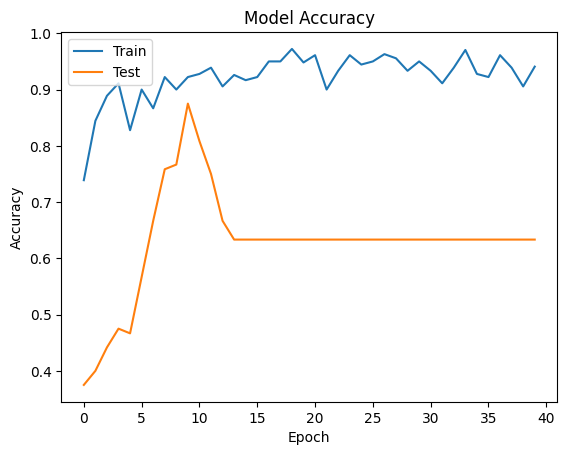

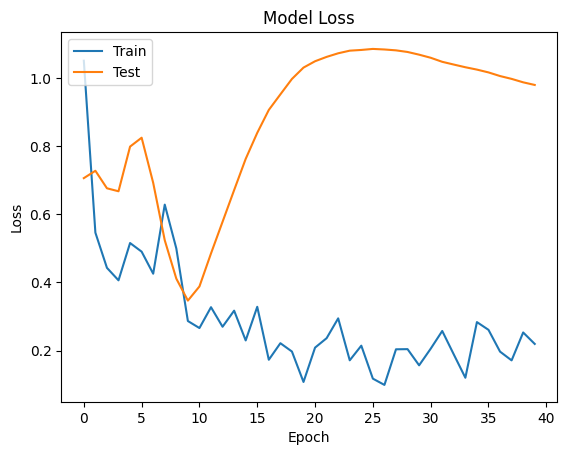

In [40]:
plot_loss_accuracy(history)


### TRANSFER LEARNING - MobileNet + DENSE

In [41]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential

import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential

import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

def hand_segmentation_preprocessing(image):
    """Preprocessing per isolare la mano dallo sfondo"""
    # 1. Converti in HSV per segmentazione colore
    hsv = tf.image.rgb_to_hsv(image)
    
    # 2. Filtra per tonalità della pelle (regola questi valori)
    lower_skin = tf.constant([0.0, 0.2, 0.0], dtype=tf.float32)
    upper_skin = tf.constant([0.1, 1.0, 1.0], dtype=tf.float32)
    mask = tf.logical_and(
        tf.greater(hsv, lower_skin),
        tf.less(hsv, upper_skin))
    mask = tf.cast(mask, tf.float32)
    
    # 3. Applica la maschera e normalizza
    masked_image = image * mask
    normalized = masked_image / 255.0  # Normalizza a [0,1]
    
    return normalized

def robust_mobilenetv2_hand_classifier(input_shape=(120, 120, 3), num_classes=2):
    # Input layer con preprocessing
    inputs = Input(shape=input_shape)
    
    # Preprocessing personalizzato (solo durante il training)
    if tf.keras.backend.learning_phase():
        x = tf.keras.layers.Lambda(hand_segmentation_preprocessing)(inputs)
    else:
        x = inputs / 255.0  # Solo normalizzazione durante l'inferenza
    
    # Aggiungi augmentations per robustezza alla luce
    if tf.keras.backend.learning_phase():
        x = tf.keras.layers.RandomBrightness(0.3)(x)
        x = tf.keras.layers.RandomContrast(0.3)(x)
    
    # Base model
    base_model = MobileNetV2(
        input_tensor=x,
        weights='imagenet',
        include_top=False,
        alpha=0.35  # Versione più leggera (1.0 è la default)
    )
    
    # Fine-tuning configurabile
    base_model.trainable = True
    for layer in base_model.layers[:100]:
        layer.trainable = False
    
    # Top model
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(128, activation='relu', 
              kernel_regularizer=regularizers.l2(0.01))(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    # Model compilation
    model = Model(inputs, outputs)
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

#### Model 5: 
Mobilenet + DENSE

In [42]:
input_shape = next(train_generator)[0].shape[1:]  # Ottieni la forma delle immagini dal generatore

# Usa include_top=False per permettere input_shape diverso da (224, 224, 3)
base_model = keras.applications.MobileNet(
    input_shape=input_shape,
    include_top=False,
    weights='imagenet'
)

x = base_model.output
x = GlobalAveragePooling2D()(x)
output = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

In [43]:
callbacks_list = model_callbacks("model_mobilenet_dense")

steps_per_epoch, validation_steps = calculate_steps(len(train_doc), len(val_doc), batch_size)


train_generator = generate(train_path, train_doc, batch_size)
val_generator   = generate(val_path, val_doc, batch_size)

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

Chiavi disponibili in history: dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])


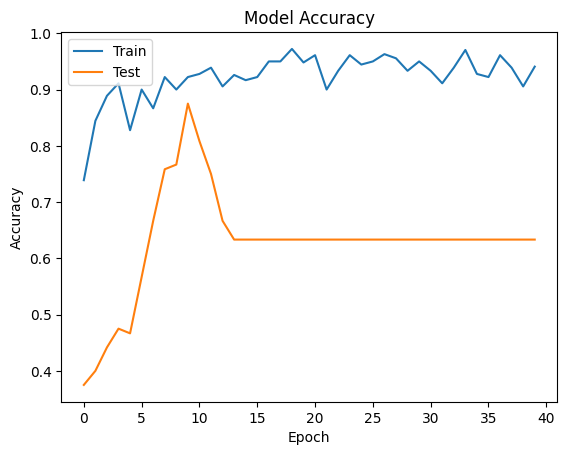

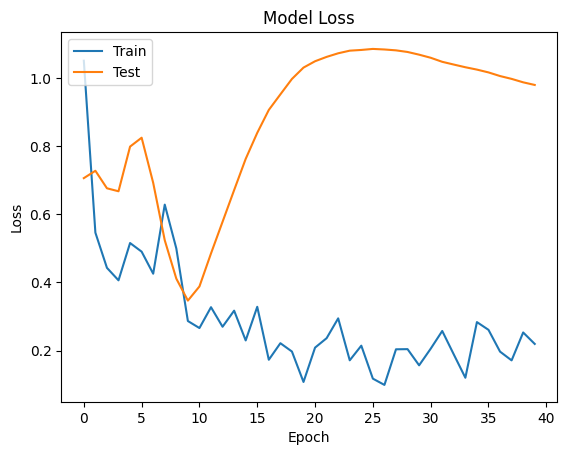

In [44]:
plot_loss_accuracy(history)

#### Model 6: 
Mobilenet (re train all weights) + GRU (128 cells) + 128 dense nodes + Random data transformations on training data set

In [45]:
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D


def mobilenet_dense_variant(input_shape=(120, 120, 3), fine_tune=False, dense_nodes=128, dropout=0.3, num_classes=2):
    # Carica MobileNet senza il top (strati densi finali)
    base_model = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Se non vogliamo fare fine-tuning, blocchiamo i pesi
    if not fine_tune:
        for layer in base_model.layers:
            layer.trainable = False
    
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),  # Sostituisce Flatten per ridurre i parametri
        Dense(256, activation='relu'),
        Dropout(dropout),
        Dense(dense_nodes, activation='relu'),
        Dropout(dropout),
        Dense(num_classes, activation='softmax')  # Output finale
    ])

    # Compilazione del modello
    opt = Adam(learning_rate=0.0001)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [46]:
callbacks_list = model_callbacks("model_30_retrain_mobilenet_dense_variant")

steps_per_epoch, validation_steps = calculate_steps(len(train_doc), len(val_doc), batch_size)


train_generator = generate(train_path, train_doc, batch_size)
val_generator   = generate(val_path, val_doc, batch_size)

In [ ]:
history = model.fit(
    train_generator, 
    steps_per_epoch=steps_per_epoch, 
    epochs=num_epochs, 
    verbose=1, 
    callbacks=callbacks_list, 
    validation_data=val_generator, 
    validation_steps=validation_steps, 
    class_weight=None, 
    initial_epoch=0
)

Chiavi disponibili in history: dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])


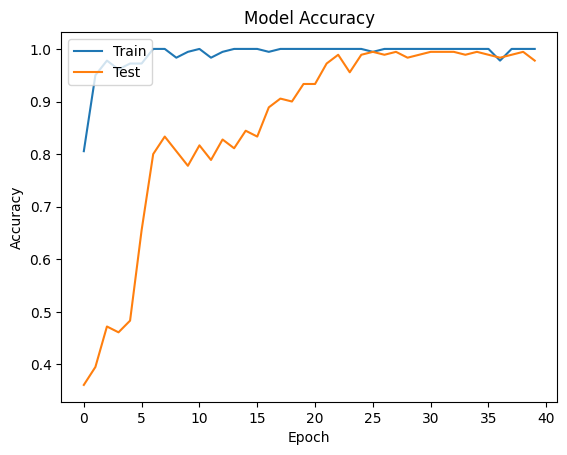

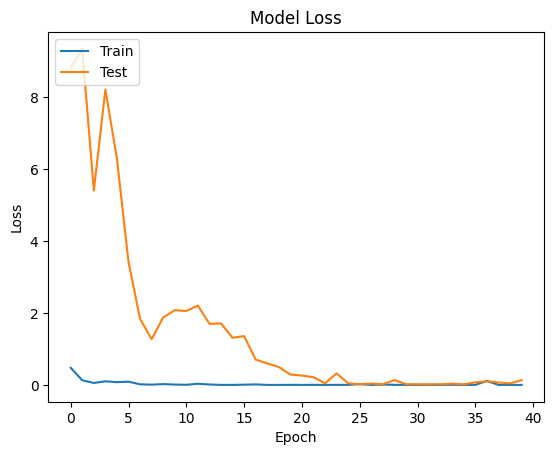

In [48]:
plot_loss_accuracy(history)